In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Bin function converts integer into base 2 binary
print(bin(4))

# int('binary', 'base') function can turn binary of given base back into in integer 
print(int(bin(4),2))

0b100
4


In [3]:
# Morton order achieved by interleaving bits
# x = 3, bin(x) = '0b11' ==> '0b00011' to match length of y
# y = 22, bin(y) = '0b10110'
# 
# Interleaving with x binary in even positions, and y in odd, gives
# 
# (morton number) m = '0b1000101101'

def to_morton(x,y):
    bx = bin(x)[2:] # ignore '0b' before binary encoding
    by = bin(y)[2:]
    
    lx = len(bx)
    ly = len(by)
    
    lm = 2*max(lx,ly) # Get length must be multiple of 2 twice the length of larger of x or y
    
    m = ['0']*(lm)
    
    for i in range(lx):
        m[lm - 1 - 2*i] = bx[lx - 1 - i]
    
    for i in range(ly):
        m[lm - 2 - 2*i] = by[ly - 1 - i]
        
    m = ['0b'] + m
    m = ''.join(m)
    m = int(m,2)

    return(m)


def from_morton(m):
    
    bm = bin(m)[2:]
    
    lbm = len(bm) # length of binary
    lm,r = divmod(lbm,2) # get length to nearest power of 2
    lm = (lm + r)*2
    
    lx = int(lm/2) # Length of x and y arrays
    
    m = ['0']*lm
    
    x = ['0']*lx
    y = ['0']*lx
    
    for i in range(lbm):
        m[lm - 1 - i] = bm[lbm - 1 - i]
    
    for i in range(lx):
        x[i] = m[2*i + 1]
        y[i] = m[2*i]
        
    x = ['0b'] + x
    y = ['0b'] + y
    x = ''.join(x)
    y = ''.join(y)
    x = int(x,2)
    y = int(y,2)
        
    return(x,y)

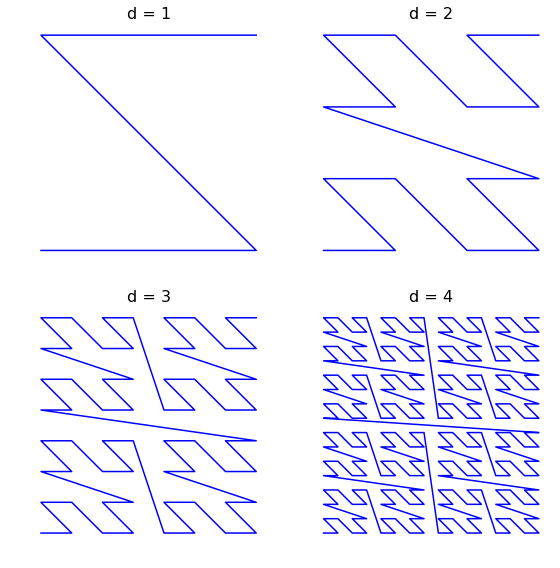

In [4]:
fig,ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))

for depth in range(1,5):

    x = np.arange(2**depth)
    y = x

    n = (2**depth)**2
    m = [None]*n
    xm = [None]*n
    ym = [None]*n

    i = 0
    for xx in x:
        for yy in y:
            xm[i] = xx
            ym[i] = yy
            m[i] = to_morton(xx,yy)
            i = i + 1

    mm,xm = zip(*sorted(zip(m, xm)))
    mm,ym = zip(*sorted(zip(m, ym)))
    
    mytitle = 'd = ' + str(depth)
    
    axi,axj = divmod(depth-1,2)

    ax[axi,axj].plot(xm,ym,'b-')
    ax[axi,axj].set_title(mytitle,fontsize = 16)
    ax[axi,axj].axis('scaled')
    ax[axi,axj].axis('off')

plt.tight_layout()
plt.show()

In [5]:
# Generate initial configuration of psi
depth = 8

# Number of grid points
M = 2**depth
N = 2**depth

# Lattice spacing 
dx = 0.05
dy = 0.05

# Length in x-direction
Lx = M*dx
Ly = N*dy

# Width of interface
zeta = Lx/20

x = np.linspace(0,Lx,N+1)
y = np.linspace(0,Ly,M+1)

xx,yy = np.meshgrid(x,y)

rr = (xx**2 + yy**2)**0.5

phi = rr - (2*Lx*Ly/np.pi)**0.5

psi = 0.5*(1 + np.tanh(phi/zeta))
original = psi

print(psi.shape)

(257, 257)


In [6]:
def gradient_2D(f,dx,dy):
    
    dfdx = np.zeros(np.shape(f))
    dfdy = np.zeros(np.shape(f))
    
    dfdx[:,1:-1] = (f[:,2:] - f[:,0:-2])/(2*dx)
    dfdx[:,0] = 0.0
    dfdx[:,-1] = 0.0
    
    dfdy[1:-1,:] = (f[2:,:] - f[0:-2,:])/(2*dy)
    dfdy[0,:] = 0.0
    dfdy[-1,:] = 0.0

    return(dfdx,dfdy)

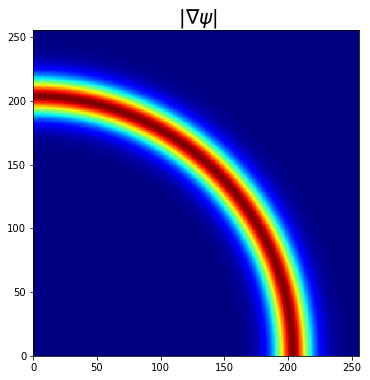

In [7]:
dpsi_dx, dpsi_dy = gradient_2D(psi,dx,dy)

mag_grad_psi = (dpsi_dy**2 + dpsi_dx**2)**0.5 # Magnitude of gradient vector

height = 6
width = (Lx/Ly)*height

# Unit cells should be centered
domain = (mag_grad_psi[1:,0:-1] + mag_grad_psi[0:-1,0:-1] + mag_grad_psi[1:,1:] + mag_grad_psi[0:-1,1:])/4

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (height,width))
ax.pcolormesh(domain, cmap = 'jet')
plt.axis('scaled')
plt.title(r" $| \nabla \psi |$ ",fontsize = 20)

plt.show()

In [8]:
def combine_criteria(area,val):
    if val*area > 0.005:
        combine = 0 # do not combine
    else:
        combine = 1 # combine 
    return(combine)

In [9]:
def morton_table(depth):
    x = np.arange(2**depth)
    y = np.arange(2**depth)
    
    m_table = np.zeros((2**depth,2**depth),dtype = 'int32')
    
    for i in range(2**depth):
        for j in range(2**depth):
            m_table[i,j] = to_morton(x[i],y[j])
            
    return(m_table)

In [10]:
# Generate morton lookup table of same dimensions as grid
m_table = morton_table(depth)

# Create morton-ordered voxel grid

val_z = np.zeros(2**depth * 2**depth)
x_z = np.zeros(2**depth * 2**depth)
y_z = np.zeros(2**depth * 2**depth)

for i in range(2**depth):
    for j in range(2**depth):
        index = m_table[i,j]
        val_z[index] = domain[i,j]
        x_z[index] = i*dx + 0.5*dx
        y_z[index] = j*dy + 0.5*dx

In [11]:
class node:
    def __init__(self,kids):
        
        self.children = []
        
        for i in range(0,4):
            self.children.append(kids[i])
            
        self.isleaf = 0
        self.isnode = 1
        
class leaf:
    def __init__(self,x,y,val):
        
        self.x = x
        self.y = y
        self.val = val
        
        self.isleaf = 1
        self.isnode = 0

In [12]:
# Initialize queue

q = []
q_num = [0]*(depth+1)

for i in range(0,depth+1):
    q.append([None,None,None,None])    
    
for i in range(int((2**depth)**2 / 4)):
    
    q_num[depth] = 0

    for j in range(4):
        
        index = 4*i + j
        q[depth][j] = leaf(x_z[index],y_z[index],val_z[index])
        q_num[depth] =  q_num[depth] + 1
        
    d = depth 
    
    while ((d > 0) and (q_num[d] == 4)):
        
        all_leaf = 1 # If all items in queue are leaves, try to combine
        
        for k in range(4):
            if q[d][k].isleaf == 0:
                all_leaf = 0   
                
        if all_leaf == 1: # Try to combine 
            
            x_avg = (q[d][0].x + q[d][1].x + q[d][2].x + q[d][3].x)/4
            y_avg = (q[d][0].y + q[d][1].y + q[d][2].y + q[d][3].y)/4
            val_avg = (q[d][0].val + q[d][1].val + q[d][2].val + q[d][3].val)/4
        
            area = (Lx/2**d)**2
            
            if combine_criteria(area,val_avg) == 1: # Combine
                q[d-1][q_num[d-1]] = leaf(x_avg,y_avg,val_avg)
                q_num[d-1] = q_num[d-1] + 1
                q_num[d] = 0
                d = d - 1
                
            else:
                q[d-1][q_num[d-1]] = node(q[d])
                q_num[d-1] = q_num[d-1] + 1
                q_num[d] = 0
                d = d - 1
            
        else: # Push back a node
            q[d-1][q_num[d-1]] = node(q[d])
            q_num[d-1] = q_num[d-1] + 1
            q_num[d] = 0
            d = d - 1

In [13]:
quadtree = q[0][0]

In [14]:
def get_leaves(quadtree,level):
    global leaf_list
    
    for i in range(4):
        
        if quadtree.children[i].isleaf == 1:
            
            myleaf =  quadtree.children[i]
            x = myleaf.x
            y = myleaf.y
            val = myleaf.val
            
            info = [level + 1,x,y,val]
            leaf_list.append(info)
            
        else:
            
            mynode = quadtree.children[i]
            get_leaves(mynode,level + 1)

In [15]:
leaf_list = []
get_leaves(quadtree,0)

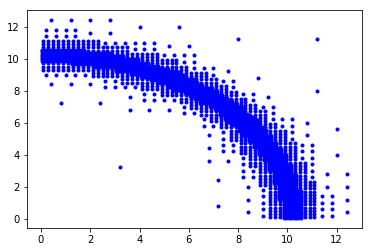

In [16]:
x_vals = []
y_vals = []
psi_vals = []
level_vals = []

for i in range(0,len(leaf_list)):
    point = leaf_list[i]
    
    level = point[0]
    x = point[1]
    y = point[2]
    psi = point[3]
    
    level_vals.append(level)
    x_vals.append(x)
    y_vals.append(y)
    psi_vals.append(psi)

plt.plot(x_vals,y_vals,'b.')
plt.show()

In [17]:
reconstructed = np.zeros(domain.shape)
mygrid = np.zeros(domain.shape)

for i in range(len(x_vals)):
    ival = round(2**depth*x_vals[i]/Lx)
    jval = round(2**depth*y_vals[i]/Ly)
    
    h = 0.5*2**(depth - level_vals[i])
    
    left = int(max(ival - h, 0))
    right = int(min(ival + h, 2**depth - 1))
    top = int(max(jval - h,0))
    bottom = int(min(jval + h, 2**depth - 1))
    
    reconstructed[left:right,top:bottom] = psi_vals[i]
    mygrid[left,top:bottom] = 1.0
    mygrid[right,top:bottom] = 1.0
    mygrid[left:right,top] = 1.0
    mygrid[left:right,bottom] = 1.0


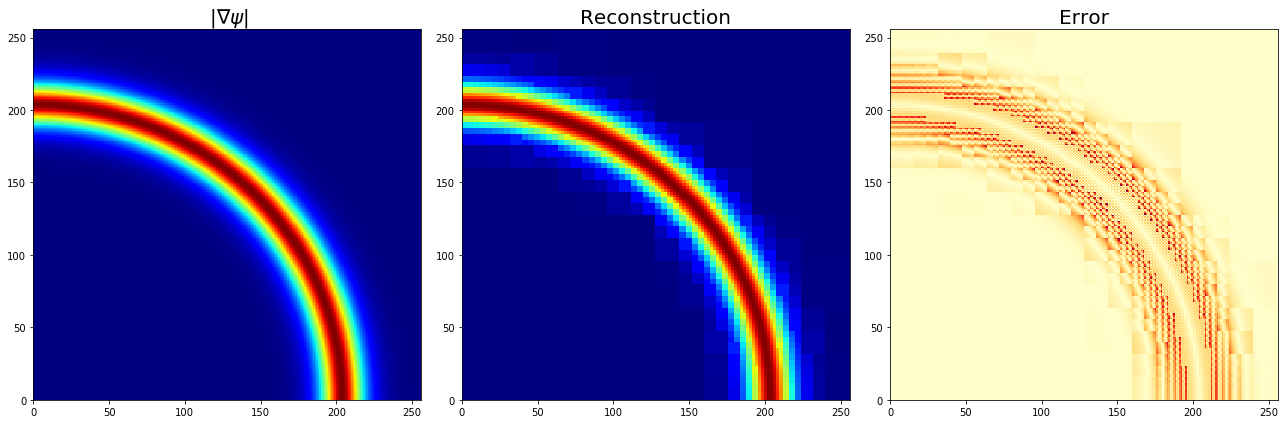

In [18]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (height*3,width))

ax[0].pcolormesh(domain, cmap = 'jet')
#ax[0].axis('scaled')
ax[0].set_title(r" $| \nabla \psi |$ ",fontsize = 20)

ax[1].pcolormesh(reconstructed, cmap = 'jet')
#ax[1].axis('scaled')
ax[1].set_title("Reconstruction",fontsize = 20)

ax[2].pcolormesh(np.abs(reconstructed - domain), cmap = 'YlOrRd')
#ax[2].axis('scaled')
ax[2].set_title("Error",fontsize = 20)

plt.tight_layout()
plt.show()

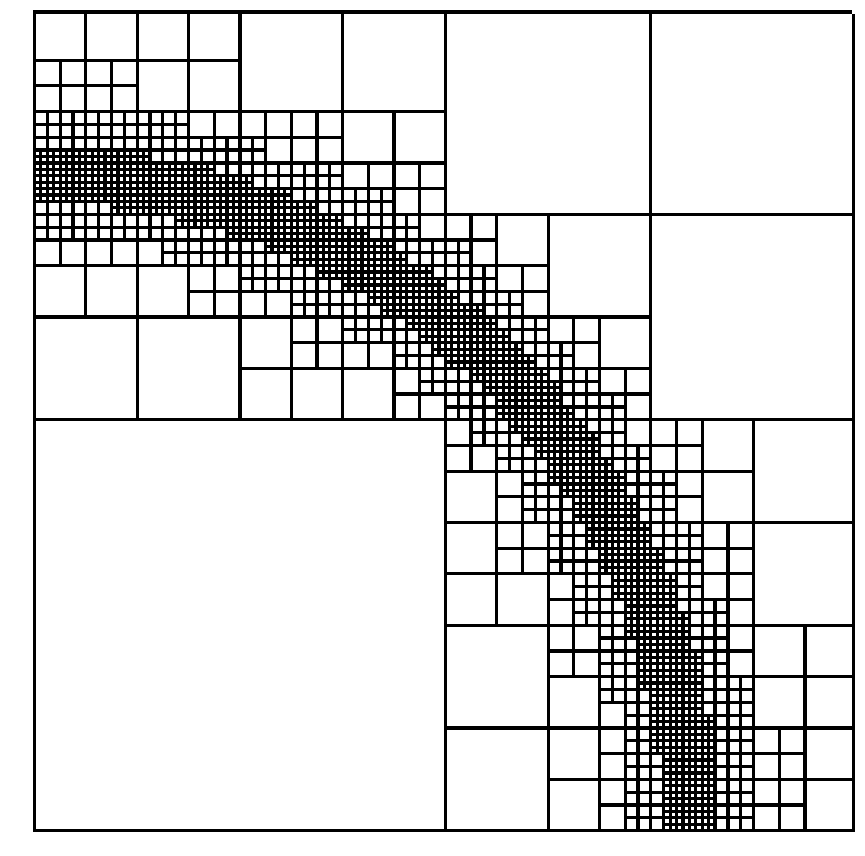

In [19]:
plt.close('all')

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (height*2,width*2))

ax.pcolormesh(mygrid, cmap = 'binary')
ax.axis('scaled')
ax.axis('off')

plt.tight_layout()
plt.show()